# Anomaly Detection with Isolation Forest Algorithm

Hello and welcome to my solution of catching anomalities in credit accounts!
I first start by loading the data set and getting descriptive statistics.

In [1]:
!pip install  tensorflow==2.7.0 -q
!pip install scikeras -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx-bsl 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tfx-bsl 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.7.0 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.7.0 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflow<3,>=2.9.0, but you have tensorflow 2.7.0 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow<2.7.0,>=2.6.0, but you have tensorflow 2.7.0 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesyst

## Loading the data, checking variable names & values to determine categorical variables.

In [29]:
import pandas as pd
data = pd.read_csv('/kaggle/input/anomaly-detection/CaseStudy_AnomalyDetection_202012.csv', 
                   sep=';')
data.head()

,Target,Var_1,Var_2,Var_3,Var_4,Var_5,Var_6,Var_7,Var_8,Var_9,...,Var_31,Var_32,Var_33,Var_34,Var_35,Var_36,Var_37,Var_38,Var_39,Var_40
0,0,N,X,3.0,1331.0,0.0,1.0,Y,Y,Y,...,NaN,0,14.0,L,Y,0.0,0.0,0.0,0,NaN
1,0,N,X,4.0,1174.0,6002.0,1.0,Y,Y,Y,...,0,0,8.0,O,Y,0.0,0.0,0.0,0,NaN
2,0,N,X,2.0,980.0,2455.0,0.0,Y,Y,Y,...,NaN,0,22.0,L,Y,0.0,0.0,0.0,0,NaN
3,0,N,X,6.0,1070.0,632.0,0.0,Y,N,Y,...,NaN,0,0.0,L,N,0.0,0.0,0.0,0,NaN
4,0,N,X,0.0,1257.0,200.0,0.0,Y,Y,Y,...,1,0,22.0,I,Y,0.0,0.0,0.0,0,NaN


In [3]:
var_name_dict = dict()
with open('/kaggle/input/anomaly-detection/Dictionary.txt', 'r', encoding='ISO-8859-1') as infile:
    content = infile.read().split('\n')
    for i, line in enumerate(content):
        splt = line.split('\t\t')
        if len(splt) == 2:
            var_name_dict[splt[0]] = splt[1]
var_name_dict

{'Target': 'Never Paid or not',
 'Var_1': 'Restructured Credit Request YN',
 'Var_2': 'Customer GBF',
 'Var_3': 'CC_Num_of_application_L6M + LO_Num_of_application_L6M + MO_Num_of_application_L6M + OD_Num_of_application_L6M',
 'Var_4': 'KKB Bureau Score',
 'Var_5': 'CC Total Payment of all Credit cards',
 'Var_6': 'CC_Num_of_application_L1M + LO_Num_of_application_L1M + OD_Num_of_application_L1M',
 'Var_7': 'Employers Address YN',
 'Var_8': 'Branch and work adresses are the same',
 'Var_9': 'Main and application branch codes are the same',
 'Var_10': 'Müþteri Dönem Aktif',
 'Var_11': 'Monthly Family Income',
 'Var_12': 'OD Number of months in 1 delay_L24M',
 'Var_13': 'OD Number of months in 2 delay_L12M',
 'Var_14': 'CC Number of months in 2 delay_L24M',
 'Var_15': 'Kullandýrým Hazýrlýk',
 'Var_16': 'Þube Müdürü Görüþü',
 'Var_17': 'Þube Kaps Kontrolü',
 'Var_18': 'CC Tot Limit YTL',
 'Var_19': 'Total_of_Monthly_Instalment / Total_Assets',
 'Var_20': 'CC_Total_Payment_of_all_Credit_car

In [4]:
import numpy as np
for col in data.columns:
    unique_vals = data[col].unique()
    print(col, unique_vals)

Target [0 1]
Var_1 ['N' nan 'Y']
Var_2 ['X' 'B' 'G' nan 'I']
Var_3 [  3.   4.   2.   6.   0.  11.   1.   5.   7.  nan   8.   9.  17.  10.
  19.  12.  13.  14.  20.  48.  30.  21.  18.  16.  15.  33.  23.  24.
  25.  36.  63.  34.  26.  27.  22.  31.  42.  29.  28.  53.  44.  37.
  41.  50.  47.  38.  32.  85.  40.  39.  70.  46.  49.  35. 109.  45.
 112.  60.  52.  80.  56.  43.  65.]
Var_4 [1331. 1174.  980. ...  592.  533.  535.]
Var_5 [   0. 6002. 2455. ... 4687. 9402. 5727.]
Var_6 [ 1.  0.  2. nan  7.  4.  3.  9.  6.  5.  8. 10. 14. 21. 17. 13. 11. 15.
 12. 16. 27. 24. 19. 39.]
Var_7 ['Y' 'N' nan]
Var_8 ['Y' 'N']
Var_9 ['Y' 'N']
Var_10 [1 0]
Var_11 [ 4000.  5900.  2000. ...  6748.  6260. 16090.]
Var_12 [nan  7.  0.  2.  3.  1.  4. 21.  5.  8.  6. 16. 20. 28. 10. 11. 24.  9.
 26. 13. 25. 12. 17. 15. 18. 23. 22. 14. 34.]
Var_13 [nan  4.  0.  2.  1.  3.  6.  5. 15.  8.]
Var_14 [nan  6.  3.  0.  1.  2.  4.  5.  8. 15.  9.  7. 10. 13. 11. 19. 26. 12.
 16.]
Var_15 [1 0]
Var_16 [0 1]
Var_

In [5]:
categorical_vars = [1,2,7,8,9,10,15,16,17,21,22,23,27,28,31,30,33,34,35,39,40]

## Data Analysis

In [7]:
print('Dataset Size:', len(data))

Dataset Size: 75000


Variable Analysis for Target (Never Paid or not)

Percentage of empty values: 0.00%

Unique values: [0 1]

Distribution of values:


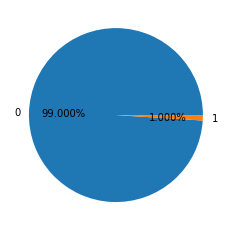

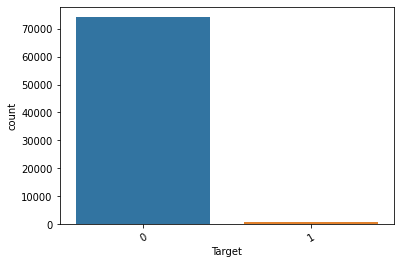

-------------------------------------

Variable Analysis for Var_1 (Restructured Credit Request YN)

Percentage of empty values: 0.64%

Unique values: ['N' 'Y']

Distribution of values:


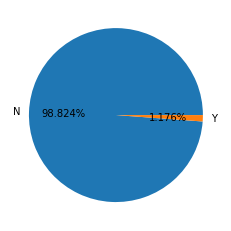

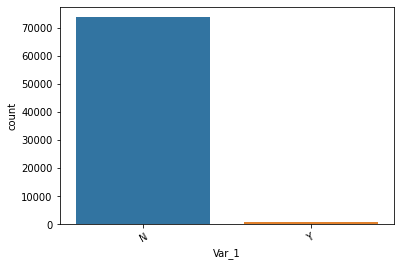

-------------------------------------

Variable Analysis for Var_2 (Customer GBF)

Percentage of empty values: 2.61%

Unique values: ['X' 'B' 'G' 'I']

Distribution of values:


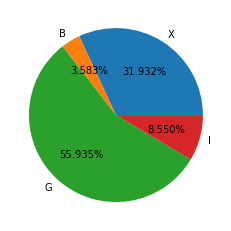

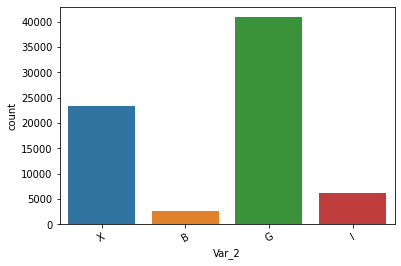

-------------------------------------

Variable Analysis for Var_3 (CC_Num_of_application_L6M + LO_Num_of_application_L6M + MO_Num_of_application_L6M + OD_Num_of_application_L6M)

Percentage of empty values: 0.62%

Descriptive Statistics:
count    74537.000000
mean         3.074876
std          3.711363
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        112.000000
Name: Var_3, dtype: float64

Data Distribution:


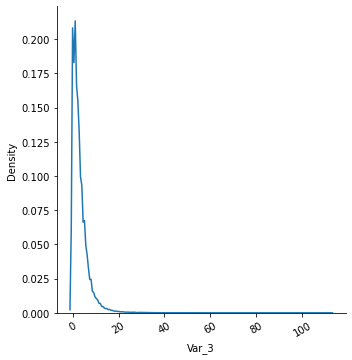

Skew: 4.163740705096755
Kurtosis: 46.745625178322314

Q-Q Plot:


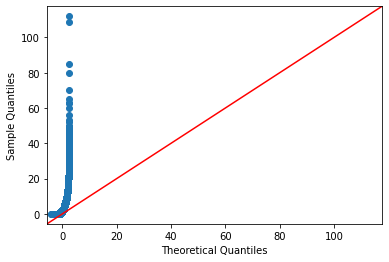

-------------------------------------

Variable Analysis for Var_4 (KKB Bureau Score)

Percentage of empty values: 0.67%

Descriptive Statistics:
count    74497.000000
mean      1233.861605
std        341.665804
min          0.000000
25%       1094.000000
50%       1268.000000
75%       1432.000000
max       1900.000000
Name: Var_4, dtype: float64

Data Distribution:


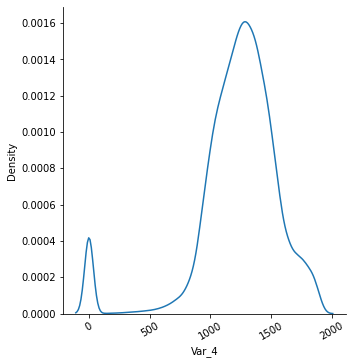

Skew: -1.586535813810845
Kurtosis: 4.331757750008762

Q-Q Plot:


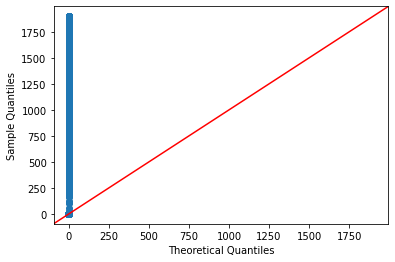

-------------------------------------

Variable Analysis for Var_5 (CC Total Payment of all Credit cards)

Percentage of empty values: 0.67%

Descriptive Statistics:
count     74497.000000
mean       1475.148194
std        4486.814036
min           0.000000
25%           7.000000
50%         500.000000
75%        1450.000000
max      404590.000000
Name: Var_5, dtype: float64

Data Distribution:


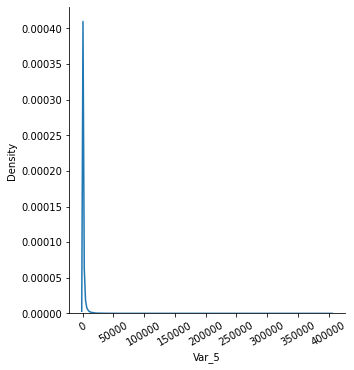

Skew: 25.05889179818699
Kurtosis: 1394.8151818849108

Q-Q Plot:


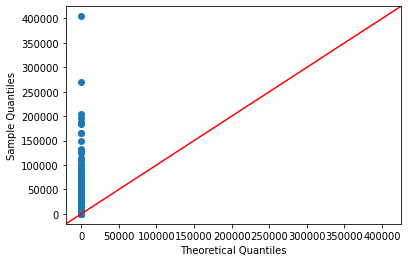

-------------------------------------

Variable Analysis for Var_6 (CC_Num_of_application_L1M + LO_Num_of_application_L1M + OD_Num_of_application_L1M)

Percentage of empty values: 0.62%

Descriptive Statistics:
count    74537.000000
mean         0.849940
std          1.249142
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         39.000000
Name: Var_6, dtype: float64

Data Distribution:


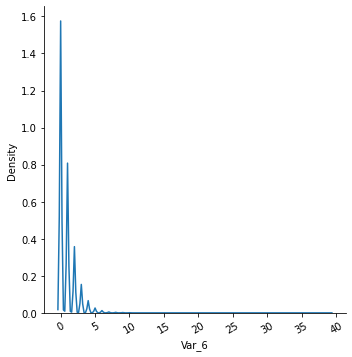

Skew: 3.1669057351761447
Kurtosis: 30.77219314776923

Q-Q Plot:


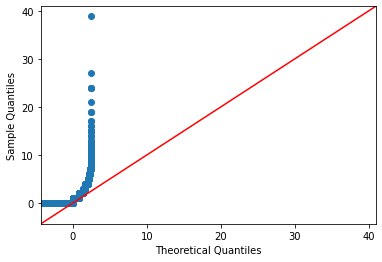

-------------------------------------

Variable Analysis for Var_7 (Employers Address YN)

Percentage of empty values: 0.64%

Unique values: ['Y' 'N']

Distribution of values:


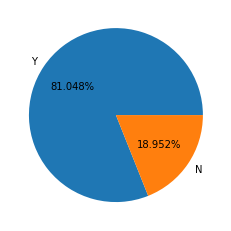

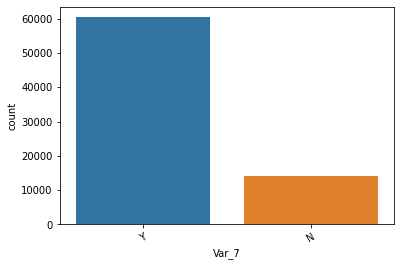

-------------------------------------

Variable Analysis for Var_8 (Branch and work adresses are the same)

Percentage of empty values: 0.00%

Unique values: ['Y' 'N']

Distribution of values:


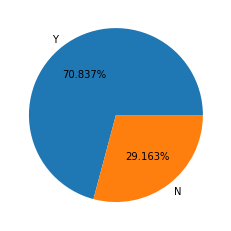

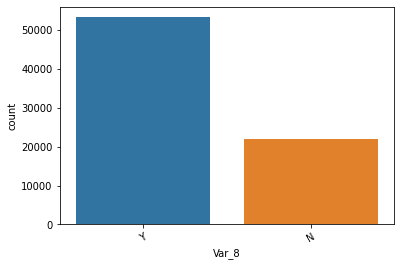

-------------------------------------

Variable Analysis for Var_9 (Main and application branch codes are the same)

Percentage of empty values: 0.00%

Unique values: ['Y' 'N']

Distribution of values:


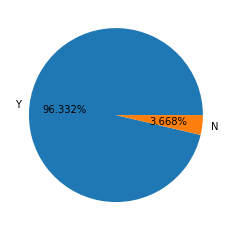

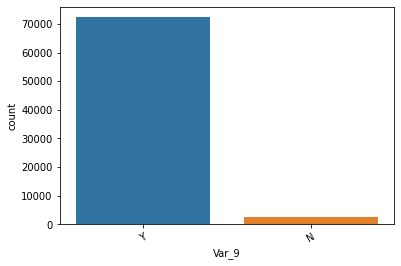

-------------------------------------

Variable Analysis for Var_10 (Müþteri Dönem Aktif)

Percentage of empty values: 0.00%

Unique values: [1 0]

Distribution of values:


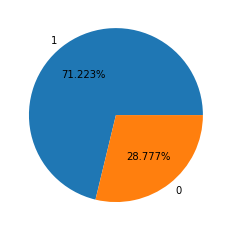

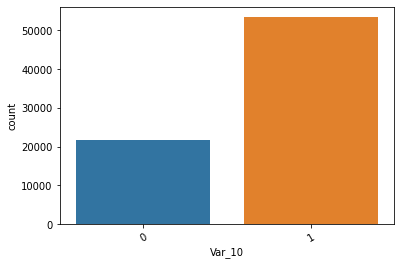

-------------------------------------

Variable Analysis for Var_11 (Monthly Family Income)

Percentage of empty values: 0.66%

Descriptive Statistics:
count    7.450400e+04
mean     2.160155e+04
std      4.727668e+06
min      0.000000e+00
25%      1.621000e+03
50%      2.500000e+03
75%      4.180000e+03
max      1.290439e+09
Name: Var_11, dtype: float64

Data Distribution:


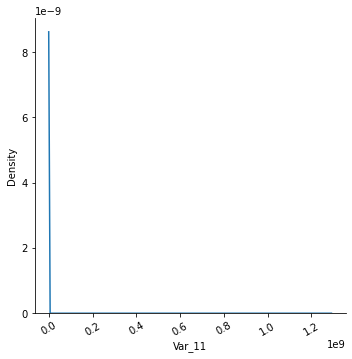

Skew: 272.9471402935322
Kurtosis: 74498.42756071295

Q-Q Plot:


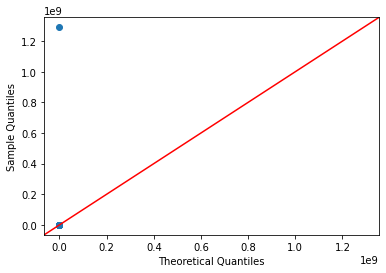

-------------------------------------

Variable Analysis for Var_12 (OD Number of months in 1 delay_L24M)

Percentage of empty values: 97.22%

Descriptive Statistics:
count    2083.000000
mean        1.765723
std         3.829813
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max        34.000000
Name: Var_12, dtype: float64

Data Distribution:


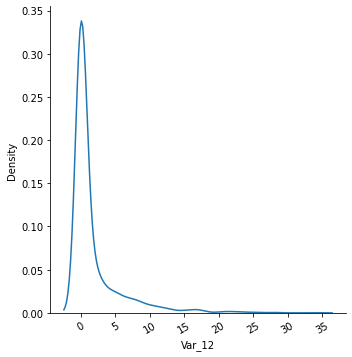

Skew: 3.2451058546077136
Kurtosis: 12.958365122171266

Q-Q Plot:


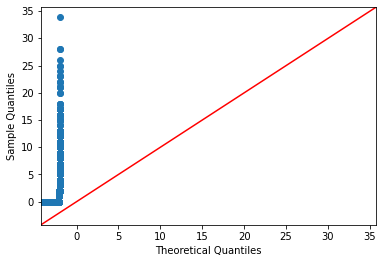

-------------------------------------

Variable Analysis for Var_13 (OD Number of months in 2 delay_L12M)

Percentage of empty values: 97.22%

Descriptive Statistics:
count    2083.000000
mean        0.146423
std         0.639081
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        15.000000
Name: Var_13, dtype: float64

Data Distribution:


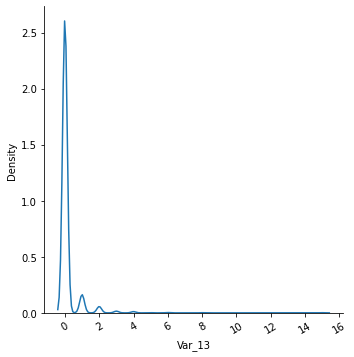

Skew: 9.789927039769548
Kurtosis: 165.3080182716599

Q-Q Plot:


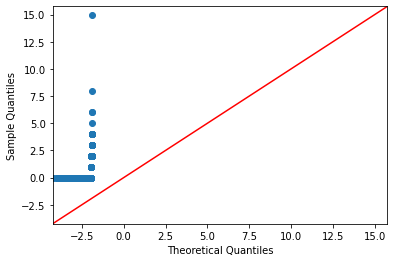

-------------------------------------

Variable Analysis for Var_14 (CC Number of months in 2 delay_L24M)

Percentage of empty values: 96.80%

Descriptive Statistics:
count    2403.000000
mean        0.711194
std         1.793871
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        26.000000
Name: Var_14, dtype: float64

Data Distribution:


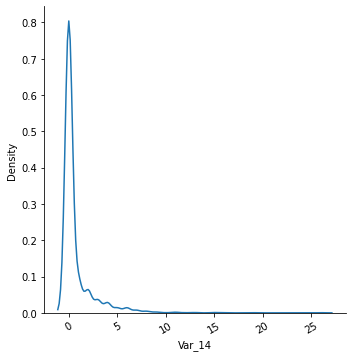

Skew: 4.504298359301205
Kurtosis: 32.97674435752592

Q-Q Plot:


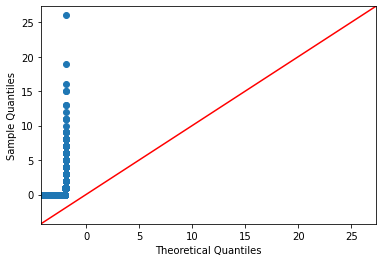

-------------------------------------

Variable Analysis for Var_15 (Kullandýrým Hazýrlýk)

Percentage of empty values: 0.00%

Unique values: [1 0]

Distribution of values:


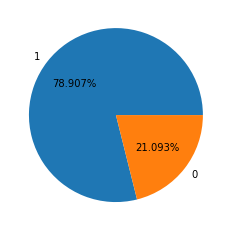

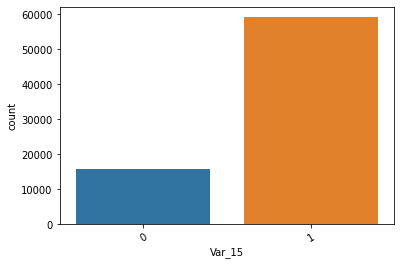

-------------------------------------

Variable Analysis for Var_16 (Þube Müdürü Görüþü)

Percentage of empty values: 0.00%

Unique values: [0 1]

Distribution of values:


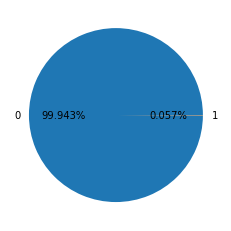

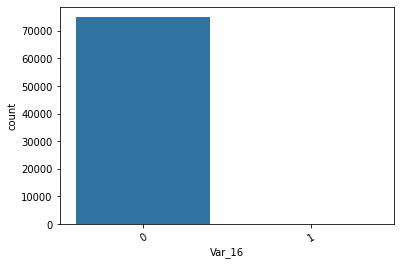

-------------------------------------

Variable Analysis for Var_17 (Þube Kaps Kontrolü)

Percentage of empty values: 0.00%

Unique values: [0 1]

Distribution of values:


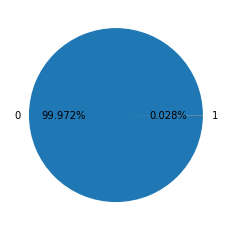

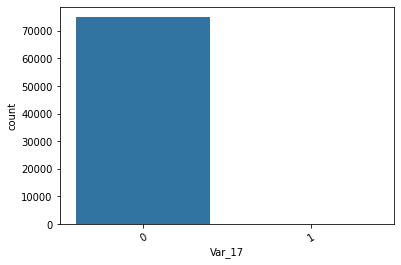

-------------------------------------

Variable Analysis for Var_18 (CC Tot Limit YTL)

Percentage of empty values: 0.67%

Descriptive Statistics:
count     74497.000000
mean      11119.156731
std       22437.986065
min           0.000000
25%        1500.000000
50%        5000.000000
75%       11880.000000
max      854550.000000
Name: Var_18, dtype: float64

Data Distribution:


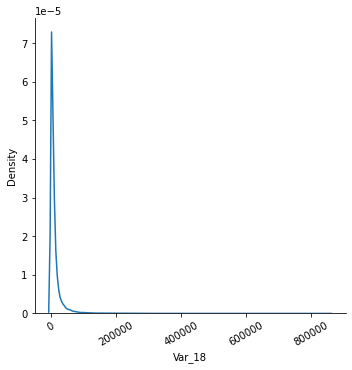

Skew: 8.431676916721937
Kurtosis: 148.34485164651957

Q-Q Plot:


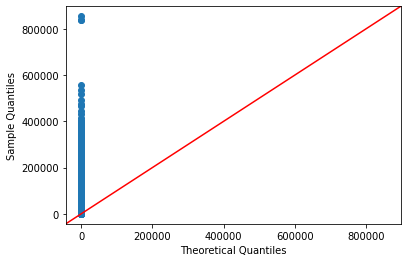

-------------------------------------

Variable Analysis for Var_19 (Total_of_Monthly_Instalment / Total_Assets)

Percentage of empty values: 0.62%

Descriptive Statistics:
count    74537.000000
mean        30.053382
std        208.698740
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      14969.000000
Name: Var_19, dtype: float64

Data Distribution:


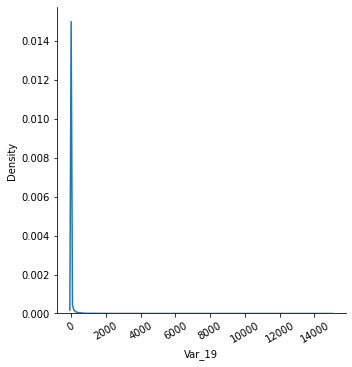

Skew: 28.311274921065472
Kurtosis: 1423.9740655452879

Q-Q Plot:


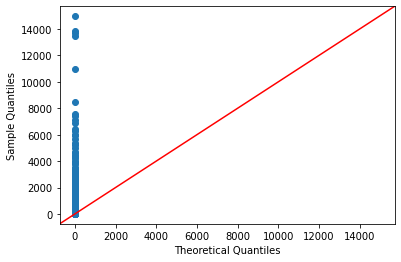

-------------------------------------

Variable Analysis for Var_20 (CC_Total_Payment_of_all_Credit_cards / CC_Total_Balance_of_All_Credit_Cards)

Percentage of empty values: 0.62%

Descriptive Statistics:
count    74537.000000
mean         1.363676
std         64.393863
min          0.000000
25%          0.000000
50%          0.201803
75%          0.414663
max      15994.000000
Name: Var_20, dtype: float64

Data Distribution:


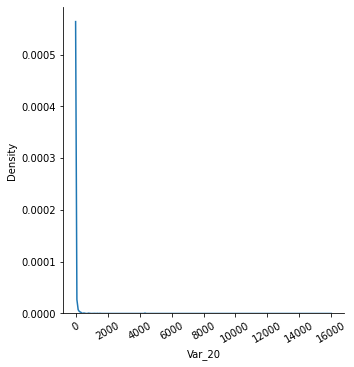

Skew: 211.95876426068656
Kurtosis: 51378.26372086467

Q-Q Plot:


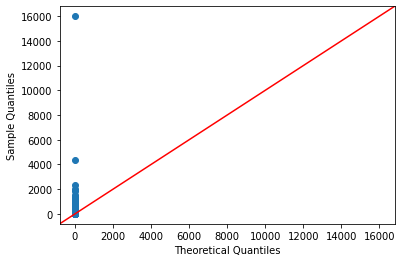

-------------------------------------

Variable Analysis for Var_21 (Worst Card Status ALL)

Percentage of empty values: 34.73%

Unique values: ['N' 'D' 'G']

Distribution of values:


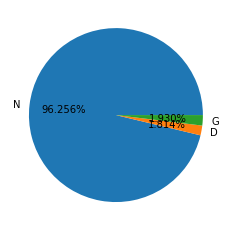

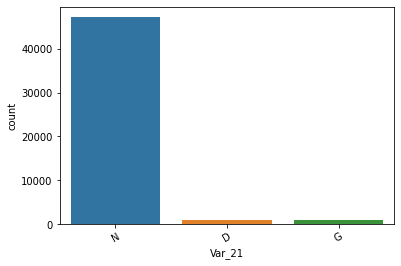

-------------------------------------

Variable Analysis for Var_22 (Home Phone YN)

Percentage of empty values: 0.66%

Unique values: ['N' 'Y']

Distribution of values:


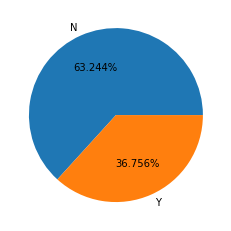

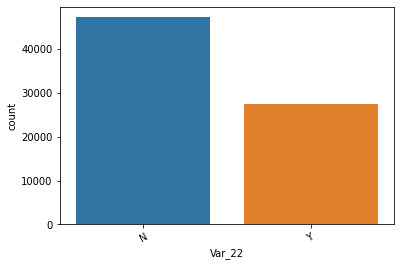

-------------------------------------

Variable Analysis for Var_23 (Þube Pazarlama Eksiklik Görüþü)

Percentage of empty values: 0.00%

Unique values: [0 1]

Distribution of values:


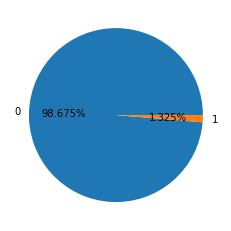

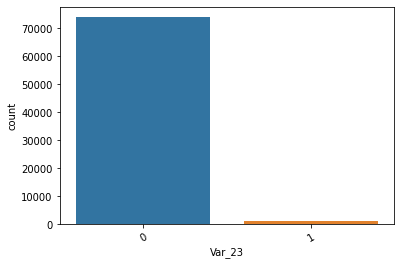

-------------------------------------

Variable Analysis for Var_24 (GUA_Num Unpaid Cheques L6M)

Percentage of empty values: 0.64%

Descriptive Statistics:
count    74520.000000
mean         0.000483
std          0.121385
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         33.000000
Name: Var_24, dtype: float64

Data Distribution:


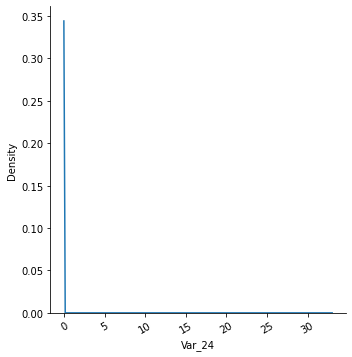

Skew: 269.8310999460808
Kurtosis: 73303.40076133037

Q-Q Plot:


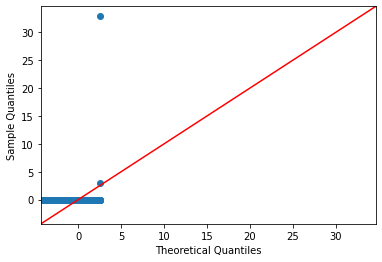

-------------------------------------

Variable Analysis for Var_25 (Number of Limit Increase Rejects in L3M)

Percentage of empty values: 87.18%

Descriptive Statistics:
count    9615.000000
mean        0.059282
std         0.311724
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Var_25, dtype: float64

Data Distribution:


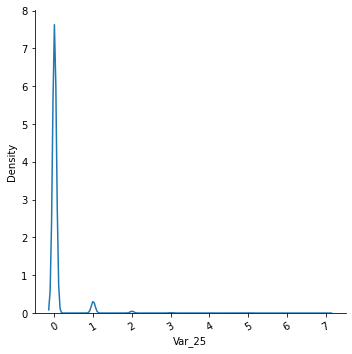

Skew: 8.323660411493542
Kurtosis: 105.42232809867467

Q-Q Plot:


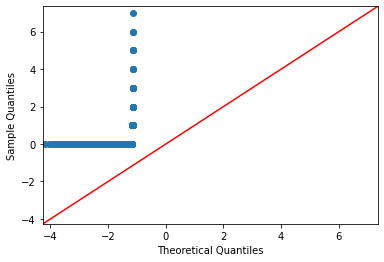

-------------------------------------

Variable Analysis for Var_26 (Total_of_Monthly_Instalment / Monthly Net Income)

Percentage of empty values: 0.62%

Descriptive Statistics:
count    74537.000000
mean         0.129016
std          5.398335
min          0.000000
25%          0.000000
50%          0.000000
75%          0.131700
max       1151.000000
Name: Var_26, dtype: float64

Data Distribution:


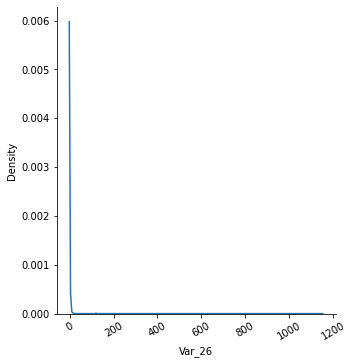

Skew: 192.64088830432823
Kurtosis: 38122.997851372376

Q-Q Plot:


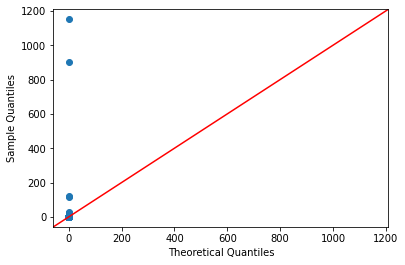

-------------------------------------

Variable Analysis for Var_27 (Residential Status)

Percentage of empty values: 7.43%

Unique values: [1. 5. 3. 4. 2.]

Distribution of values:


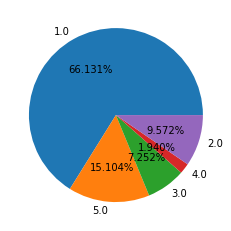

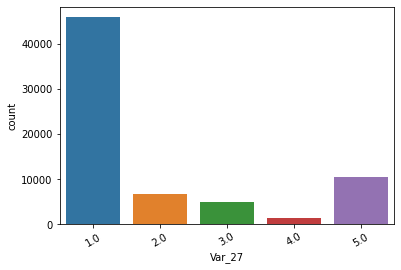

-------------------------------------

Variable Analysis for Var_28 (Max Delinquency Status L6M)

Percentage of empty values: 21.30%

Unique values: [0. 2. 4. 3. 5. 7.]

Distribution of values:


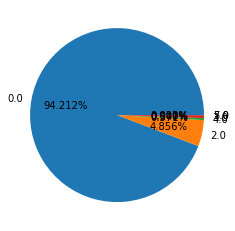

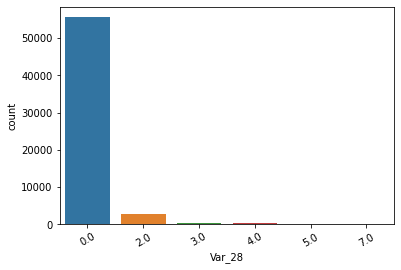

-------------------------------------

Variable Analysis for Var_29 (Num Unpaid Notes L7M_L12M)

Percentage of empty values: 0.64%

Descriptive Statistics:
count    74520.000000
mean         0.000510
std          0.038066
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          6.000000
Name: Var_29, dtype: float64

Data Distribution:


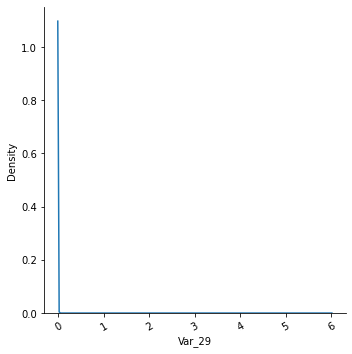

Skew: 104.08635289955599
Kurtosis: 12876.044672012327

Q-Q Plot:


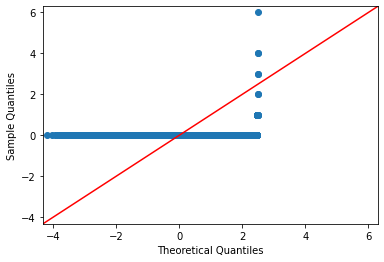

-------------------------------------

Variable Analysis for Var_30 (Aktif Vadeli Grup)

Percentage of empty values: 0.00%

Unique values: [0 1]

Distribution of values:


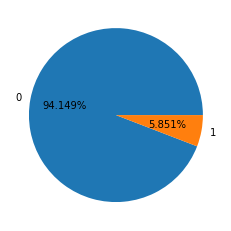

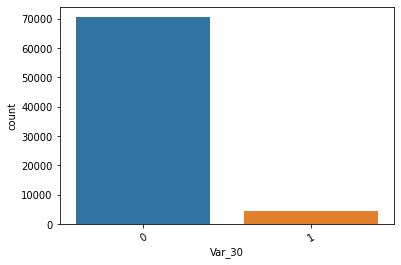

-------------------------------------

Variable Analysis for Var_31 (Current Payment Status)

Percentage of empty values: 48.15%

Unique values: ['0' '1' 'U' '2' '3' '6' '4']

Distribution of values:


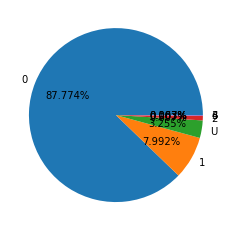

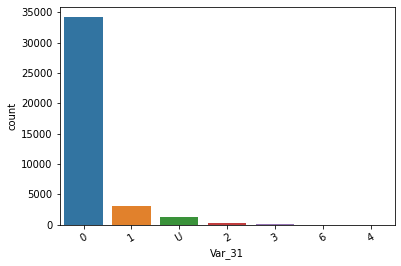

-------------------------------------

Variable Analysis for Var_32 (Bayii Bekleme Havuzu)

Percentage of empty values: 0.00%

Descriptive Statistics:
count    75000.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: Var_32, dtype: float64

Data Distribution:


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


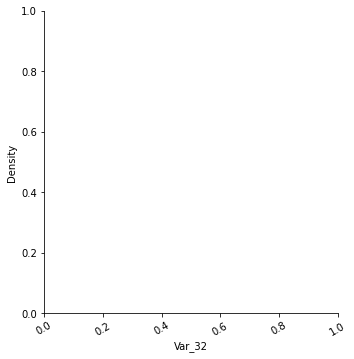

Skew: 0.0
Kurtosis: -3.0

Q-Q Plot:


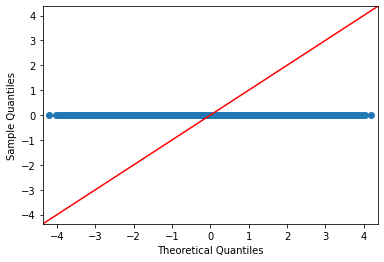

-------------------------------------

Variable Analysis for Var_33 (Home adress district code)

Percentage of empty values: 1.82%

Unique values: [14.  8. 22.  0. 11. 13.  7. 17. 20. 10. 40.  5.  4. 35. 24. 37. 30. 16.
 18. 12. 15. 21.  9.  3.  2.  1.  6. 28. 23. 38. 26. 33. 19. 31. 25. 27.
 39. 29. 36. 32. 41. 34. 42.]

Distribution of values:


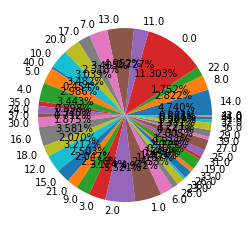

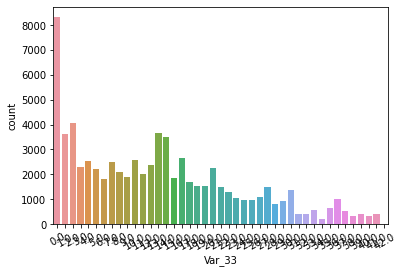

-------------------------------------

Variable Analysis for Var_34 (Level of Education)

Percentage of empty values: 5.67%

Unique values: ['L' 'O' 'I' 'N' 'U' 'Y']

Distribution of values:


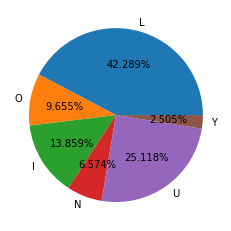

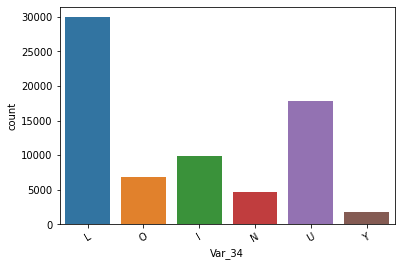

-------------------------------------

Variable Analysis for Var_35 (Branch and home adresses have the same city code)

Percentage of empty values: 0.00%

Unique values: ['Y' 'N']

Distribution of values:


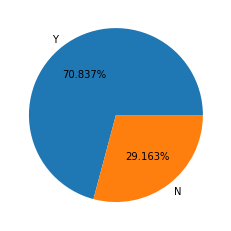

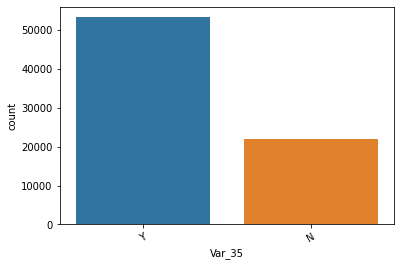

-------------------------------------

Variable Analysis for Var_36 (LO Tot Balance in Litigation)

Percentage of empty values: 0.65%

Descriptive Statistics:
count     74515.000000
mean         20.064645
std         959.688466
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      146810.000000
Name: Var_36, dtype: float64

Data Distribution:


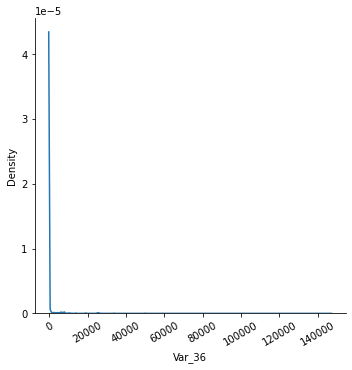

Skew: 94.3937174669361
Kurtosis: 11342.413599533567

Q-Q Plot:


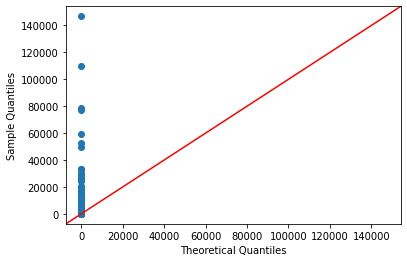

-------------------------------------

Variable Analysis for Var_37 (Num Unpaid Cheques L13M-L24M)

Percentage of empty values: 0.64%

Descriptive Statistics:
count    74520.000000
mean         0.002026
std          0.467932
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        127.000000
Name: Var_37, dtype: float64

Data Distribution:


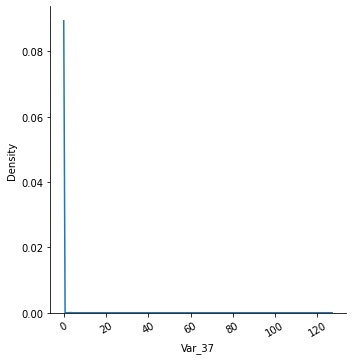

Skew: 268.56694677257633
Kurtosis: 72815.79640273498

Q-Q Plot:


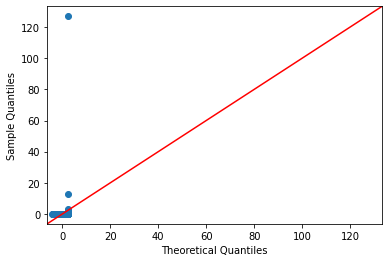

-------------------------------------

Variable Analysis for Var_38 (MO_Maximum_Mortgage_Limit / Monthly Net Income)

Percentage of empty values: 0.65%

Descriptive Statistics:
count    74515.000000
mean         4.631313
std        308.884529
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      63750.000000
Name: Var_38, dtype: float64

Data Distribution:


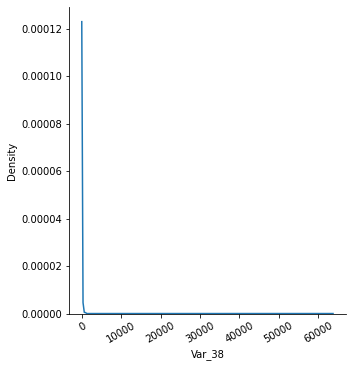

Skew: 193.70770027784837
Kurtosis: 37826.37802153795

Q-Q Plot:


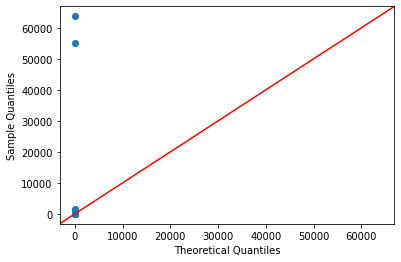

-------------------------------------

Variable Analysis for Var_39 (GM Kullandýrým Ýþlem)

Percentage of empty values: 0.00%

Unique values: [0 1]

Distribution of values:


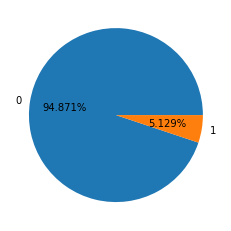

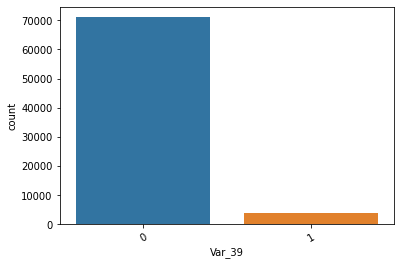

-------------------------------------

Variable Analysis for Var_40 (Preapproval_Credit_Type)

Percentage of empty values: 99.99%

Unique values: ['S' 'F' 'M']

Distribution of values:


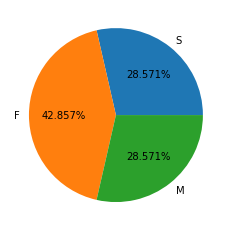

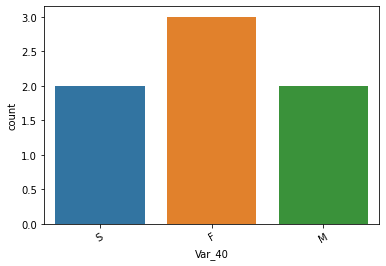

-------------------------------------



In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import statsmodels.api as sm
import pylab as py
from statistics import median, mode

for col in data.columns:
    print(f'Variable Analysis for {col} ({var_name_dict[col]})')
    print()
    
    empty_pct = (len(data[data[col].isna()])/len(data))*100
    print(f'Percentage of empty values:', '{:.2f}%'.format(empty_pct))
    print()
    
    if col == 'Target' or int(col.split('_')[1]) in categorical_vars:
        print('Unique values:', data[col].dropna().unique())
        print()
        
        print('Distribution of values:')
        y = list()
        lbls = list()
        for val in data[col].unique():
            if not pd.isna(val):
                lbls.append(val)
                y.append(len(data[data[col] == val]))
        #        var_pct = len(data[data[col] == val])/len(data)*100
        #        print(val, ':', '{:.3f}%'.format(var_pct))
        plt.pie(y, labels = lbls, autopct='%.3f%%')
        plt.show()
        
        sns.countplot(x=data[col])
        plt.xticks(rotation=30)
        plt.show()
    else:
        print('Descriptive Statistics:')
        print(data[col].describe())
        print()
        
        print('Data Distribution:')
        sns.displot(data, x=col, kind="kde")
        plt.xticks(rotation=30)
        plt.show()
        print('Skew:', skew(data[col].dropna(), bias=True))
        print('Kurtosis:', kurtosis(data[col].dropna(), bias=True))
        print()
        
        print('Q-Q Plot:')
        sm.qqplot(data[col], line ='45')
        py.show()
    print('-------------------------------------')
    print()
    

## Outlier Analysis

I am using interquartile ranges to decide which data points are outliers. I am also drawing box plots to visualize them.

In [9]:
import numpy as np
def get_outliers(var):
    Q1 = np.percentile(var , 25)
    Q3 = np.percentile(var , 75)
    IQR = Q3 - Q1
    ul = Q3 + 1.5*IQR
    ll = Q1 - 1.5*IQR
    return var[(var > ul) | (var < ll)]

Variable Analysis for Var_3 (CC_Num_of_application_L6M + LO_Num_of_application_L6M + MO_Num_of_application_L6M + OD_Num_of_application_L6M)

Box Plot:


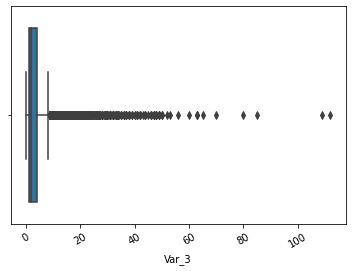

Number of outliers: 4785
Percentage of outliers: 6.42%

-------------------------------------

Variable Analysis for Var_4 (KKB Bureau Score)

Box Plot:


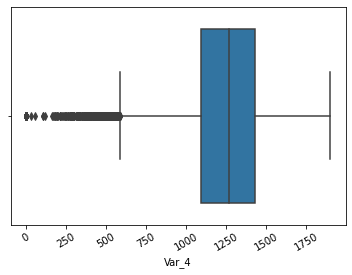

Number of outliers: 3188
Percentage of outliers: 4.28%

-------------------------------------

Variable Analysis for Var_5 (CC Total Payment of all Credit cards)

Box Plot:


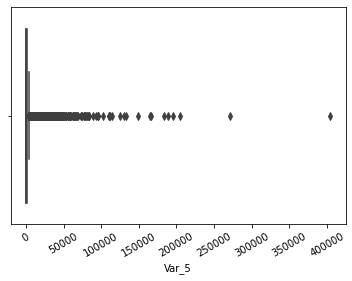

Number of outliers: 6550
Percentage of outliers: 8.79%

-------------------------------------

Variable Analysis for Var_6 (CC_Num_of_application_L1M + LO_Num_of_application_L1M + OD_Num_of_application_L1M)

Box Plot:


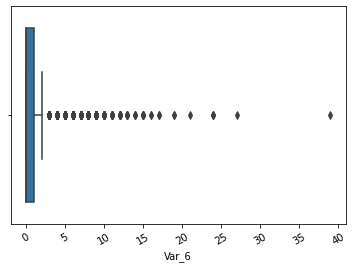

Number of outliers: 6682
Percentage of outliers: 8.96%

-------------------------------------

Variable Analysis for Var_11 (Monthly Family Income)

Box Plot:


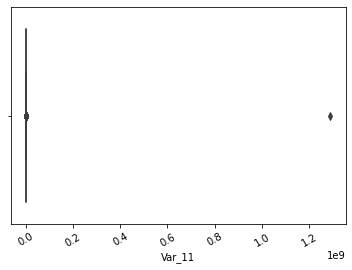

Number of outliers: 5970
Percentage of outliers: 8.01%

-------------------------------------

Variable Analysis for Var_12 (OD Number of months in 1 delay_L24M)

Box Plot:


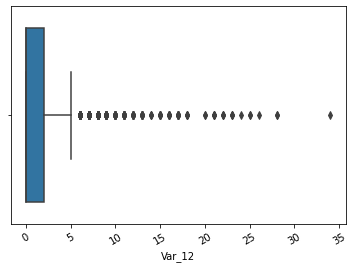

Number of outliers: 239
Percentage of outliers: 11.47%

-------------------------------------

Variable Analysis for Var_13 (OD Number of months in 2 delay_L12M)

Box Plot:


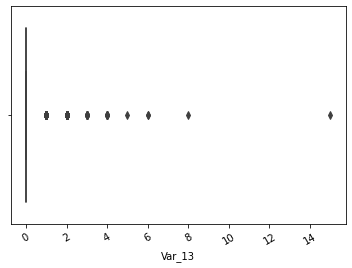

Number of outliers: 183
Percentage of outliers: 8.79%

-------------------------------------

Variable Analysis for Var_14 (CC Number of months in 2 delay_L24M)

Box Plot:


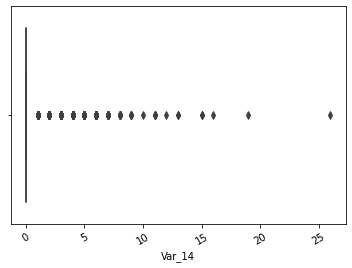

Number of outliers: 578
Percentage of outliers: 24.05%

-------------------------------------

Variable Analysis for Var_18 (CC Tot Limit YTL)

Box Plot:


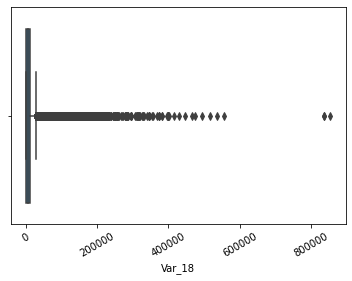

Number of outliers: 6677
Percentage of outliers: 8.96%

-------------------------------------

Variable Analysis for Var_19 (Total_of_Monthly_Instalment / Total_Assets)

Box Plot:


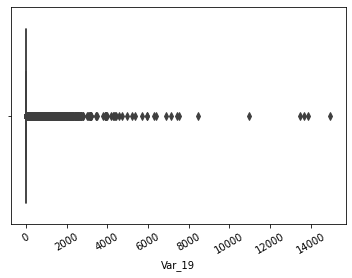

Number of outliers: 16306
Percentage of outliers: 21.88%

-------------------------------------

Variable Analysis for Var_20 (CC_Total_Payment_of_all_Credit_cards / CC_Total_Balance_of_All_Credit_Cards)

Box Plot:


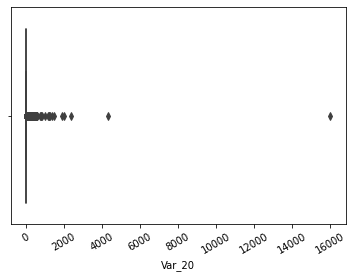

Number of outliers: 5549
Percentage of outliers: 7.44%

-------------------------------------

Variable Analysis for Var_24 (GUA_Num Unpaid Cheques L6M)

Box Plot:


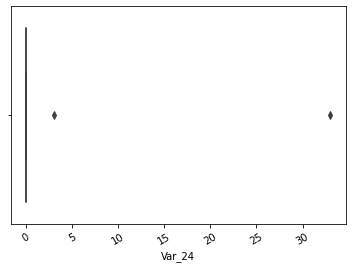

Number of outliers: 2
Percentage of outliers: 0.00%

-------------------------------------

Variable Analysis for Var_25 (Number of Limit Increase Rejects in L3M)

Box Plot:


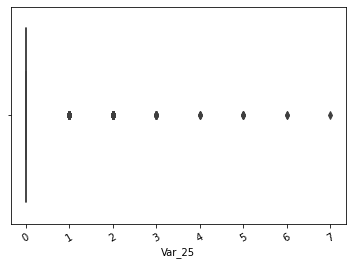

Number of outliers: 450
Percentage of outliers: 4.68%

-------------------------------------

Variable Analysis for Var_26 (Total_of_Monthly_Instalment / Monthly Net Income)

Box Plot:


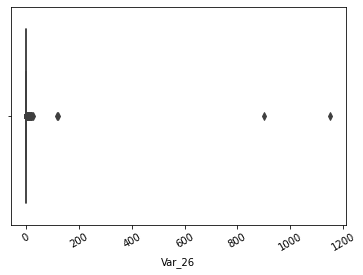

Number of outliers: 6469
Percentage of outliers: 8.68%

-------------------------------------

Variable Analysis for Var_29 (Num Unpaid Notes L7M_L12M)

Box Plot:


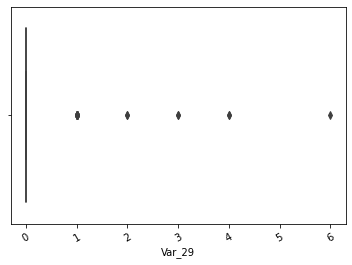

Number of outliers: 21
Percentage of outliers: 0.03%

-------------------------------------

Variable Analysis for Var_32 (Bayii Bekleme Havuzu)

Box Plot:


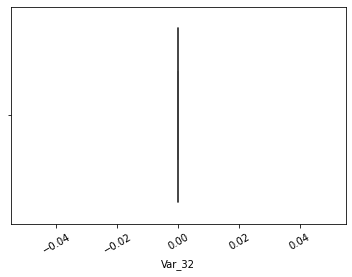

Number of outliers: 0
Percentage of outliers: 0.00%

-------------------------------------

Variable Analysis for Var_36 (LO Tot Balance in Litigation)

Box Plot:


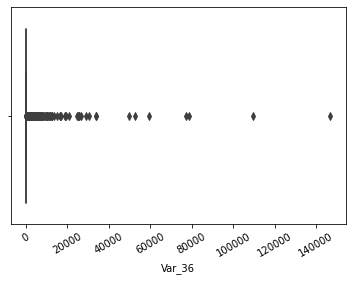

Number of outliers: 130
Percentage of outliers: 0.17%

-------------------------------------

Variable Analysis for Var_37 (Num Unpaid Cheques L13M-L24M)

Box Plot:


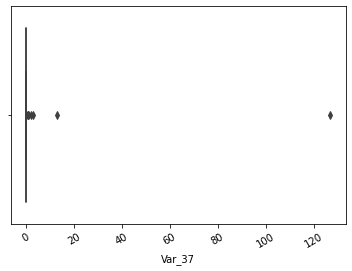

Number of outliers: 10
Percentage of outliers: 0.01%

-------------------------------------

Variable Analysis for Var_38 (MO_Maximum_Mortgage_Limit / Monthly Net Income)

Box Plot:


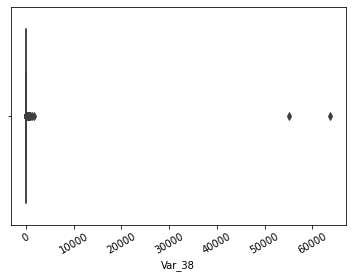

Number of outliers: 8736
Percentage of outliers: 11.72%

-------------------------------------



In [10]:
for col in data.columns:
    if len(col.split('_')) > 1 and int(col.split('_')[1]) not in categorical_vars:
        print(f'Variable Analysis for {col} ({var_name_dict[col]})')
        print()

        print('Box Plot:')
        sns.boxplot(x=data[col])
        plt.xticks(rotation=30)
        plt.show()
        outliers = get_outliers(data[col].dropna())
        print('Number of outliers:', len(outliers))
        print('Percentage of outliers:', 
              '{:.2f}%'.format((len(outliers)/len(data[col].dropna()))*100))
        
        print()
        print('-------------------------------------')
        print()

## Recoding Ordinal Variables

In [30]:
#data['Var_21'].replace(['D', 'G', 'N'], [0, 1, 2], inplace=True)
data['Var_31'].replace(['U', '0', '1', '2', '3', '4', '6'], [0, 1, 2, 3, 4, 5, 7], inplace=True)
data['Var_34'].replace(['N', 'I', 'O', 'L', 'U', 'Y'], [0, 1, 2, 3, 4, 5], inplace=True)

ordinal_vars = [28, 31, 34]

## One Hot Endoing Nominal Variables

Sklearn's one hot encoder returns all zeros for empty variables and I don't want that because I want to impute them with an imputer of choice, so i am doing one hot encoding here with pandas's get_dummies function. This function also has an option to drop one of the created encodings to avoid correlation between variables.

Var_33 represents the city code so it can take 81 distinct values. Doing one hot encoding on this variable would increase the number of variables dramatically, so in order to avoid that, I will perform target encoding on it. To avoid data leakage, i will perform it after I split the data into train and test sets. 

In [31]:
import numpy as np
city_code_var = 33
nominal_vars = [i for i in categorical_vars if i not in ordinal_vars + [city_code_var]]
frames = list()

for var in nominal_vars:
    new_df = pd.get_dummies(data[f'Var_{var}'], dummy_na=True, drop_first=True, prefix=f'Var_{var}')
    new_df.loc[(new_df[f'Var_{var}_nan'] == 1)] = np.nan
    new_df = new_df.drop(columns=f'Var_{var}_nan')
    frames.append(new_df)

new_data = pd.concat([data.drop(columns=[f'Var_{i}' for i in nominal_vars])] + frames, axis=1)

## Checking the Correlation Between Variables & Removing Highly Correlated Variables

I am removing highly correlated variables to avoid giving more weight to these features.

<AxesSubplot:>

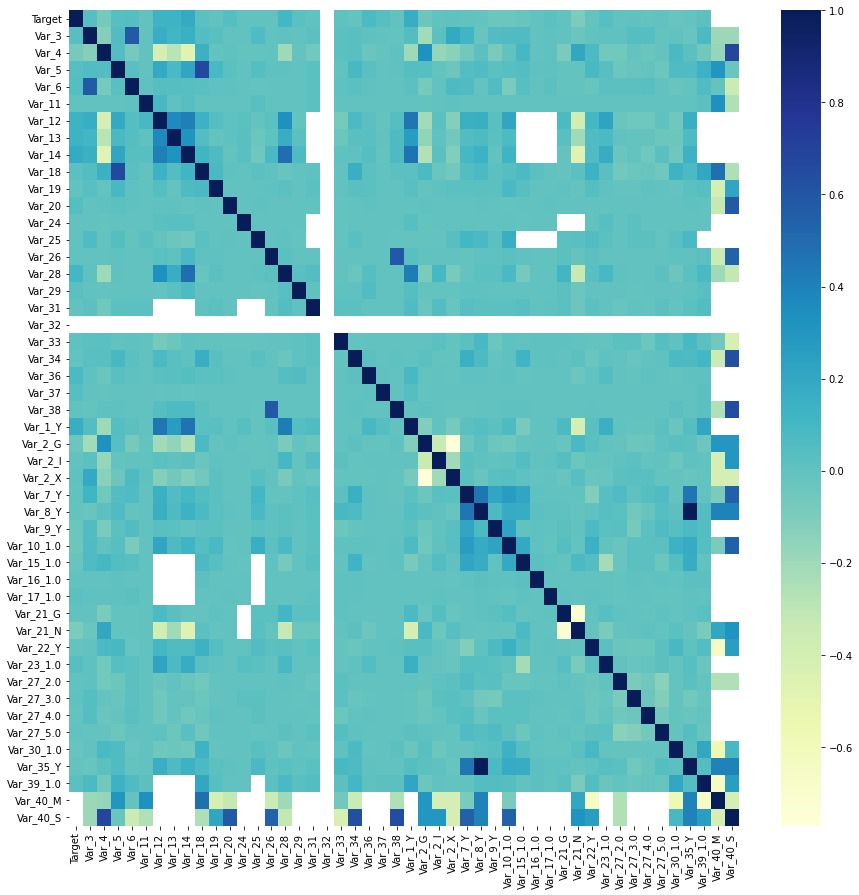

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(new_data.corr(), cmap="YlGnBu", annot=False, ax=ax)

In [33]:
corr_df = new_data.corr()
for col in corr_df.columns:
    for i, val in corr_df[col].items():
        if (val > 0.95 or val < -0.95) and col != i:
            print(col, i, val)

Var_8_Y Var_35_Y 1.0
Var_35_Y Var_8_Y 1.0


I am either going to drop Var_8 or Var_35 and I want to drop the one with having most missing values. None of them has missing values so it doesn't matter which one I drop.

In [34]:
print(len(new_data['Var_8_Y'].dropna()))
print(len(new_data['Var_35_Y'].dropna()))

75000
75000


I am also dropping Var_32 because it doesn't have any variance.

In [35]:
new_data.drop(columns='Var_8_Y', inplace=True)
new_data.drop(columns='Var_32', inplace=True)

## Splitting The Data into Train and Test Sets

When splitting into train and test sets, I am stratifying on Target to make sure I have both positive and negative targets in my sets. Because the data is highly imbalanced, this is important as otherwise I might not have any positive target values in my test set.

In [36]:
from sklearn.model_selection import train_test_split
X = new_data.drop(columns='Target')
y = new_data['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.20,
                                                    random_state=123)

## Creating A Pipeline for Scaling the Variables

I have created a pipeline for scaling variables. I am doing scaling before imputing because i intend to use knn imputer and k neighbors classifier is sensitive to the scale of variables. I am standardizing numerical variables and min max scaling categorical variables. I am also target encoding the city code variable.

In [37]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from category_encoders import TargetEncoder

target_encoding_pipe = make_pipeline(TargetEncoder(handle_missing='return_nan',
                                                   handle_unknown='return_nan'),
                                     MinMaxScaler(feature_range=(-1, 1)))
X_train[f'Var_{city_code_var}'] = X_train[f'Var_{city_code_var}'].astype('category')

cat_pipe = make_pipeline(MinMaxScaler(feature_range=(-1, 1)))
num_pipe = make_pipeline(StandardScaler())

num_cols = [c for c in data.columns if c != 'Target' and int(c.split('_')[1]) not in categorical_vars + [32]]
cat_cols = [c for c in X_train.columns if c not in num_cols + [f'Var_{city_code_var}']]

preprocessing = ColumnTransformer(
    transformers=[('target_encode', target_encoding_pipe, [f'Var_{city_code_var}']),
                  ('categorical', cat_pipe, cat_cols),
                  ('numerical', num_pipe, num_cols)])

## Creating a Deep Learning Model

I am creating a simple neural network for comparison purposes. Because my data is highly imbalanced, I am providing a bias for the output layer to make the model predict more of the underrepresented class.

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import SGD, Adam
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.initializers import Constant
from tensorflow.keras.losses import BinaryCrossentropy

def create_deep_learning_model():
    model = Sequential()
    
    neg, pos = np.bincount(data['Target'])
    output_bias = np.log([pos/neg])
    output_bias = Constant(output_bias)
    #output_bias = None
    model = Sequential([Dense(256, activation='relu',input_shape=(X_train.shape[1],)),
                        Dense(256, activation="relu"),
                        Dropout(0.3),
                        Dense(256, activation="relu"),
                        Dropout(0.3),
                        Dense(1, activation='sigmoid', bias_initializer=output_bias),])

    model.compile(Adam(learning_rate=1e-4),
                  loss=BinaryCrossentropy())
    return model

2022-12-04 18:17:29.832879: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2022-12-04 18:17:29.832942: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Doing Cross Validation to Find the Best Pipeline

I want to try few imputers and feature selection techniques to find the best strategy for the task. So I am creating pipelines and doing cross validation on them in order to minimize the effects of the data split.

For imputing I intended to use the SimpleImputer and KNNImputer, however using KNNImputer in cross validation of multiple pipelines unfortunately takes too long to train, so I ended up commenting it out.

For feature selection, I am using SelectKBest with mutual information as decision function, Random Forest Classifier and LinearSVC. L1 regularize linear models have sparse solutions, so they can be used as feature selectors. Random forests also inherently perform feature selection and they can also be used as feature selectors.

In [24]:
new_data.groupby(['Target'])['Target'].count()

Target
0    74250
1      750
Name: Target, dtype: int64

In [25]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector 
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score
import warnings
warnings.simplefilter(action='ignore', category=Warning)
from statistics import mean

imputers = {'simple': SimpleImputer(strategy='median'), 
            #'knn': KNNImputer(n_neighbors=3)
           }

feature_selectors = {'k_best': SelectKBest(score_func=mutual_info_classif, k=25),
                     #'sequential_feature_selector': SequentialFeatureSelector(KNeighborsClassifier(n_neighbors=3),
                     #                          n_features_to_select=25,
                     #                          cv=5,
                     #                          n_jobs=-1),
                     'select_from_random_forest': SelectFromModel(RandomForestClassifier()),
                     'select_from_linear_SVC': SelectFromModel(LinearSVC(C=0.01, 
                                                                         penalty="l1", 
                                                                         dual=False, 
                                                                         max_iter=10000))}

models = {'isolation_forest': IsolationForest(random_state=123, contamination=0.01),
          'deep_learning': KerasClassifier(model=create_deep_learning_model,
                                          class_weight='balanced',
                                          epochs=10, batch_size=64, verbose=0)}
for model in models.keys():
    for imputer in imputers.keys():
        if model == 'isolation_forest':
            for feature_selector in feature_selectors.keys():
                pipeline = make_pipeline(preprocessing, 
                                         imputers[imputer],
                                         feature_selectors[feature_selector],
                                         models[model])
                
                scoring = {'accuracy': make_scorer(accuracy_score), 
                           'outlier_precision': make_scorer(precision_score, pos_label=-1),
                           'inlier_precision': make_scorer(precision_score, pos_label=1),
                           'outlier_recall': make_scorer(recall_score, pos_label=-1),
                           'inlier_recall': make_scorer(recall_score, pos_label=1),
                           'outlier_f1_score': make_scorer(f1_score, pos_label=-1),
                           'inlier_f1_score': make_scorer(f1_score, pos_label=1)}

                scores = cross_validate(pipeline, 
                                        X_train, y_train.replace([0,1], [1, -1]), 
                                        scoring=scoring,
                                        cv=5,
                                        #return_train_score=True
                                       )

                print(f'Model: {model} Imputer: {imputer}, Feature Selector: {feature_selector}')
                for s in scores:
                    print(f'Mean {s}:', mean(scores[s]))
                print('---------------------------------------------------')
        
        else:
            pipeline = make_pipeline(preprocessing, 
                                     imputers[imputer],
                                     models[model])
            
            scoring = {'accuracy': make_scorer(accuracy_score), 
                       'outlier_precision': make_scorer(precision_score, pos_label=1),
                       'inlier_precision': make_scorer(precision_score, pos_label=0),
                       'outlier_recall': make_scorer(recall_score, pos_label=1),
                       'inlier_recall': make_scorer(recall_score, pos_label=0),
                       'outlier_f1_score': make_scorer(f1_score, pos_label=1),
                       'inlier_f1_score': make_scorer(f1_score, pos_label=0)}
            
            scores = cross_validate(pipeline, 
                                    X_train, y_train, 
                                    scoring=scoring,
                                    cv=5,
                                    #return_train_score=True
                                   )
            
            print(f'Model: {model} Imputer: {imputer}')
            for s in scores:
                print(f'Mean {s}:', mean(scores[s]))
            print('---------------------------------------------------')

Model: isolation_forest Imputer: simple, Feature Selector: k_best
Mean fit_time: 13.424639701843262
Mean score_time: 0.46576461791992185
Mean test_accuracy: 0.9821
Mean test_outlier_precision: 0.1046280607551555
Mean test_inlier_precision: 0.990959049346414
Mean test_outlier_recall: 0.10426977056093718
Mean test_inlier_recall: 0.9909590717080333
Mean test_outlier_f1_score: 0.10443521151731561
Mean test_inlier_f1_score: 0.9909590471931821
---------------------------------------------------
Model: isolation_forest Imputer: simple, Feature Selector: select_from_random_forest
Mean fit_time: 9.971047639846802
Mean score_time: 0.41507582664489745
Mean test_accuracy: 0.9806333333333334
Mean test_outlier_precision: 0.034490451120799244
Mean test_inlier_precision: 0.9902676800323007
Mean test_outlier_recall: 0.03586020578456537
Mean test_inlier_recall: 0.9901675078361001
Mean test_outlier_f1_score: 0.03507314721336086
Mean test_inlier_f1_score: 0.9902171397556158
-------------------------------

2022-12-04 18:31:06.005431: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2022-12-04 18:31:06.005483: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-04 18:31:06.005514: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (954342a11160): /proc/driver/nvidia/version does not exist
2022-12-04 18:31:06.005889: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the

Model: deep_learning Imputer: simple
Mean fit_time: 39.134808492660525
Mean score_time: 0.42389988899230957
Mean test_accuracy: 0.79015
Mean test_outlier_precision: 0.03353150588922068
Mean test_inlier_precision: 0.9963464212270955
Mean test_outlier_recall: 0.7116666666666667
Mean test_inlier_recall: 0.790942760942761
Mean test_outlier_f1_score: 0.06400024231582893
Mean test_inlier_f1_score: 0.8815731972693479
---------------------------------------------------


## Best Features

It seems that the best feature selector is LinearSVC, so I am using it to get the names of most important features.

In [26]:
warnings.simplefilter(action='ignore', category=Warning)

X_train_t = preprocessing.fit_transform(X_train, y_train)
X_train_t = SimpleImputer(strategy='median').fit_transform(X_train_t)

selector = SelectFromModel(LinearSVC(C=0.01, penalty="l1", dual=False, max_iter=5000))
feature_idx = selector.fit(X_train_t, y_train).get_support()
best_features = X_train.columns[feature_idx]
best_features

Index(['Var_3', 'Var_4', 'Var_6', 'Var_11', 'Var_12', 'Var_14', 'Var_18',
       'Var_19', 'Var_20', 'Var_26', 'Var_33', 'Var_34', 'Var_36', 'Var_38',
       'Var_2_G', 'Var_2_I', 'Var_2_X', 'Var_7_Y', 'Var_9_Y', 'Var_10_1.0',
       'Var_15_1.0', 'Var_16_1.0', 'Var_21_N', 'Var_27_3.0', 'Var_27_4.0',
       'Var_30_1.0', 'Var_35_Y', 'Var_39_1.0', 'Var_40_M'],
      dtype='object')

In [27]:
name_list = list()
for var in best_features:
    if len(var.split('_')) > 2:
        name = '_'.join(var.split('_')[:2])     
    else:
        name = var
    if name not in name_list:
        print(var_name_dict[name])
        name_list.append(name)

CC_Num_of_application_L6M + LO_Num_of_application_L6M + MO_Num_of_application_L6M + OD_Num_of_application_L6M
KKB Bureau Score
CC_Num_of_application_L1M + LO_Num_of_application_L1M + OD_Num_of_application_L1M
Monthly Family Income
OD Number of months in 1 delay_L24M
CC Number of months in 2 delay_L24M
CC Tot Limit YTL
Total_of_Monthly_Instalment / Total_Assets
CC_Total_Payment_of_all_Credit_cards / CC_Total_Balance_of_All_Credit_Cards
Total_of_Monthly_Instalment / Monthly Net Income
Home adress district code
Level of Education
LO Tot Balance in Litigation
MO_Maximum_Mortgage_Limit / Monthly Net Income
Customer GBF
Employers Address YN
Main and application branch codes are the same
Müþteri Dönem Aktif
Kullandýrým Hazýrlýk
Þube Müdürü Görüþü
Worst Card Status ALL
Residential Status
Aktif Vadeli Grup
Branch and home adresses have the same city code
GM Kullandýrým Ýþlem
Preapproval_Credit_Type


In [ ]:
#selector = SelectKBest(score_func=mutual_info_classif, k=25)
#feature_scores = dict()
#for i, feature in enumerate(X_train.columns):
#    feature_scores[feature] = selector.scores_[i]
#sorted_feature_scores = {k: v for k, v in sorted(feature_scores.items(), key=lambda item: item[1])}
#sorted_feature_scores

## Fine Tuning the Isolation Forest Model

After deciding on an appropriate pipeline, I want to fine tune the model to see if I can improve model performance. For the parameter search I intended to use contamination, n_estimators, n_samples, max_features and bootstrap variables, however unfortunately parameter search for all these variables takes too long to train, so I commented out some of them. Ideally, contamination should be set to the ratio of positive and negative variables, however since false negatives are more costly than false positives, I thought setting contamination higher might be helpful. This is also the reason why I decide on the best model by using the recall score for the positive class.

In [ ]:
warnings.simplefilter(action='ignore', category=Warning)

from sklearn.model_selection import GridSearchCV

best_pipeline = make_pipeline(preprocessing, 
                               SimpleImputer(strategy='median'),
                               SelectFromModel(LinearSVC(C=0.01, 
                                                         penalty="l1", 
                                                         dual=False, 
                                                         max_iter=5000)),
                               IsolationForest(random_state=123, contamination=0.1, n_jobs=-1),
                              )

scoring = {'outlier_recall': make_scorer(recall_score, pos_label=-1)}

param_grid={'isolationforest__contamination': ['auto', 0.01, 0.1, 0.2],
            'isolationforest__n_estimators': [100, 150, 200, 250, 300, 350], 
            #'isolationforest__n_samples': [256, 512, 768],
            #'isolationforest__max_features': [1, 0.8, 0.6],
            #'isolationforest__bootstrap': [True, False]
           }

best_model = GridSearchCV(best_pipeline, 
                          param_grid=param_grid, 
                          scoring=scoring, 
                          cv=5, 
                          refit='outlier_recall',
                          n_jobs=-1)

best_model.fit(X_train, y_train.replace([0,1], [1, -1]))

Unsuprisingly, highest contamination value yielded the highest recall for the anomalies.

In [41]:
print('Best Parameters:', best_model.best_params_)
print('Best Score:', best_model.best_score_)

Best Parameters: {'isolationforest__contamination': 0.2, 'isolationforest__n_estimators': 300}
Best Score: 0.5651496672168486


## Evaluating the Isolation Forest Model

With the fine tuned parameters, I am again doing a cross validation to see if the model has overfit.

In [48]:
#warnings.simplefilter(action='ignore', category=Warning)
pipeline = make_pipeline(preprocessing, 
                         SimpleImputer(strategy='median'),
                         SelectFromModel(LinearSVC(C=0.01, 
                                                   penalty="l1", 
                                                   dual=False, 
                                                   max_iter=5000)),
                         IsolationForest(random_state=123, 
                                         contamination=0.2,
                                         n_estimators=300,
                                         n_jobs=-1),
                              )

scoring = {'accuracy': make_scorer(accuracy_score), 
           'outlier_precision': make_scorer(precision_score, pos_label=-1),
           'inlier_precision': make_scorer(precision_score, pos_label=1),
           'outlier_recall': make_scorer(recall_score, pos_label=-1),
           'inlier_recall': make_scorer(recall_score, pos_label=1),
           'outlier_f1_score': make_scorer(f1_score, pos_label=-1),
           'inlier_f1_score': make_scorer(f1_score, pos_label=1)}

scores = cross_validate(pipeline, 
                        X_train, y_train.replace([0,1], [1, -1]), 
                        scoring=scoring,
                        cv=5,
                        #return_train_score=True
                        )

for s in scores:
    print(f'Mean {s}:', mean(scores[s]))

Mean fit_time: 46.744957256317136
Mean score_time: 1.2435832977294923
Mean test_accuracy: 0.7998666666666666
Mean test_outlier_precision: 0.026003592103224175
Mean test_inlier_precision: 0.9940163087465971
Mean test_outlier_recall: 0.5227879538897092
Mean test_inlier_recall: 0.80267576662786
Mean test_outlier_f1_score: 0.0495303415350115
Mean test_inlier_f1_score: 0.8881470719173626


In [42]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = best_model.best_estimator_.predict(X_test)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred)
print()
print('ROC AUC:', roc_auc)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.80      0.89     14850
           1       0.03      0.59      0.06       150

    accuracy                           0.80     15000
   macro avg       0.51      0.70      0.47     15000
weighted avg       0.99      0.80      0.88     15000

Confusion Matrix:
[[11874  2976]
 [   61    89]]

ROC AUC: 0.6964646464646465


It seems there is not much of a difference between the cross validation and test set scores, so we can say that the model has not overfit.

## Fine Tuning Classification Threshold

Now I want to see if I can find a threshold that maximizes the difference between number of true positives and false positives.

Optimal threshold value is: 0.23725864372226657


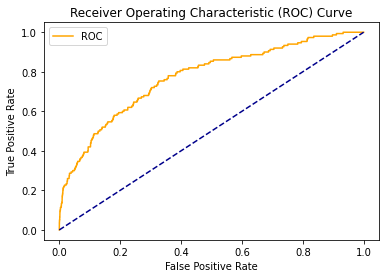

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80     14850
           1       0.02      0.75      0.04       150

    accuracy                           0.67     15000
   macro avg       0.51      0.71      0.42     15000
weighted avg       0.99      0.67      0.80     15000

Confusion Matrix:
[[9997 4853]
 [  37  113]]

ROC AUC: 0.7132659932659933


In [49]:
warnings.simplefilter(action='ignore', category=Warning)

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

sample_scores = best_model.best_estimator_.score_samples(X_test)

y_pred = MinMaxScaler(feature_range=(0, 1)).fit_transform(-sample_scores.reshape(-1, 1))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold value is:", optimal_threshold)

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

y_pred[y_pred >= optimal_threshold] = 1
y_pred[y_pred < optimal_threshold] = 0

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred)
print()
print('ROC AUC:', roc_auc)

## Evaluating the Deep Learning Model

In [50]:
dl_model = make_pipeline(preprocessing, 
                         SimpleImputer(strategy='median'),
                         KerasClassifier(model=create_deep_learning_model, 
                                         epochs=30, 
                                         batch_size=64, 
                                         verbose=0,
                                         class_weight='balanced'))
dl_model.fit(X_train, y_train)

y_pred = dl_model.predict(X_test)

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred)
print()
print('ROC AUC:', roc_auc)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     14850
           1       0.03      0.63      0.06       150

    accuracy                           0.82     15000
   macro avg       0.51      0.73      0.48     15000
weighted avg       0.99      0.82      0.89     15000

Confusion Matrix:
[[12166  2684]
 [   55    95]]

ROC AUC: 0.7262962962962963


## Fine tuning Classification Threshold

Optimal threshold value is: 0.6706901


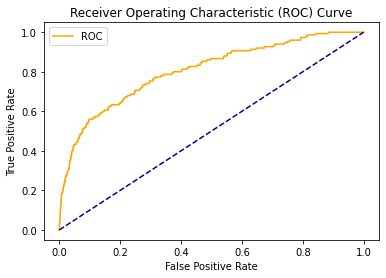

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     14850
           1       0.05      0.56      0.10       150

    accuracy                           0.90     15000
   macro avg       0.52      0.73      0.52     15000
weighted avg       0.99      0.90      0.94     15000

Confusion Matrix:
[[13403  1447]
 [   66    84]]

ROC AUC: 0.7312794612794613


In [51]:
y_pred = dl_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1])

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold value is:", optimal_threshold)

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


new_y_pred = np.zeros((len(X_test),))
new_y_pred[y_pred[:, 1] >= optimal_threshold] = 1

print('Classification Report:')
print(classification_report(y_test, new_y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, new_y_pred))

roc_auc = roc_auc_score(y_test, new_y_pred)
print()
print('ROC AUC:', roc_auc)